In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import math

%matplotlib inline

In [14]:
train_df = pd.read_csv('data/cs-training.csv', index_col=0)

In [15]:
#train_df = train_df.drop_duplicates()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

###### Rename some of the columns with dashes in the name as they are taken as minus by python ######

In [16]:
train_df=train_df.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30_59DaysPastDueNotWorse', 
                                  'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60_89DaysPastDueNotWorse'})

###### Handle NAs. There are two features with NAs. MonthlyIncome and NumberOfDependents. ######

In [17]:
train_df=train_df.fillna(value={'MonthlyIncome':train_df.MonthlyIncome.mean(), 
                                'NumberOfDependents':train_df.NumberOfDependents.mean()})

In [18]:
train_df['MonthlyIncome']=train_df.MonthlyIncome.apply(lambda x: math.log1p(x))
train_df['DebtRatio']=train_df.DebtRatio.apply(lambda x: math.log1p(x))
train_df['RevolvingUtilizationOfUnsecuredLines']=\
                            train_df.RevolvingUtilizationOfUnsecuredLines.apply(lambda x: math.log1p(x))

In [19]:
train_df['NumberOfTimesDaysLate']=101*train_df['NumberOfTimes90DaysLate'] + \
                                  51*train_df['NumberOfTime60_89DaysPastDueNotWorse'] + \
                                  23*train_df['NumberOfTime30_59DaysPastDueNotWorse']

In [20]:
train_df=train_df.drop(['NumberOfTimes90DaysLate',
                        'NumberOfTime60_89DaysPastDueNotWorse',
                        'NumberOfTime30_59DaysPastDueNotWorse'], axis=1)

In [21]:
train_df=train_df[train_df.age > 0]

In [22]:
y_train_df = train_df.SeriousDlqin2yrs
X_train_df = train_df.drop('SeriousDlqin2yrs', axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e82f630>]], dtype=object)

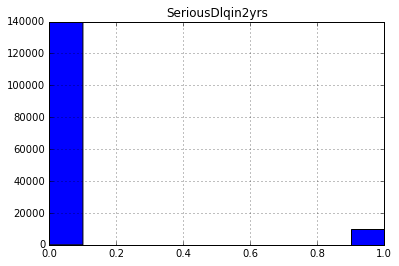

In [23]:
train_df.hist(column=['SeriousDlqin2yrs'])

In [24]:
random_state=42

In [25]:
x_train, x_rest, y_train, y_rest = train_test_split(X_train_df, y_train_df, 
                                                    test_size=0.2, 
                                                    random_state=random_state, 
                                                    stratify=y_train_df)

In [26]:
train_mat = xgb.DMatrix(x_train, y_train)

In [27]:
params = {'eta':0.1, 'seed':random_state, 'subsample':0.8,
          'colsample_bytree':0.8, 'objective': 'binary:logistic', 
          'max_depth':3, 'min_child_weight':1}

In [28]:
gbm_cv = xgb.cv(params=params, dtrain=train_mat, stratified=True,
                num_boost_round=3000, nfold=5, 
                metrics=['auc'], early_stopping_rounds=100)

In [29]:
gbm_cv.tail(5)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
189,0.865229,0.003274,0.875402,0.000595
190,0.865221,0.003277,0.875441,0.000585
191,0.865223,0.003266,0.875507,0.000544
192,0.865230,0.003243,0.875556,0.000552
193,0.865252,0.003230,0.875606,0.000556


In [30]:
final_gbm = xgb.train(params, train_mat, num_boost_round=200) 

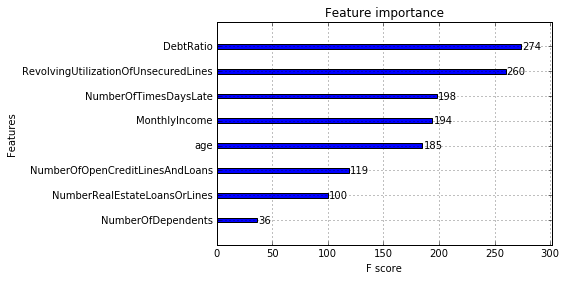

In [31]:
xgb.plot_importance(final_gbm)

In [32]:
test_mat = xgb.DMatrix(x_rest)

In [33]:
y_preds = final_gbm.predict(test_mat)

In [34]:
from sklearn import metrics

In [35]:
metrics.roc_auc_score(y_rest,y_preds)

0.8702242251132305

In [36]:
test_df = pd.read_csv('data/cs-test.csv',index_col=0)

In [37]:
test_df=test_df.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30_59DaysPastDueNotWorse', 
                                'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60_89DaysPastDueNotWorse'})

In [38]:
test_df=test_df.fillna(value={'MonthlyIncome':test_df.MonthlyIncome.mean(), 
                              'NumberOfDependents':test_df.NumberOfDependents.mean()})

In [39]:
test_df['MonthlyIncome']=test_df.MonthlyIncome.apply(lambda x: math.log1p(x))
test_df['DebtRatio']=test_df.DebtRatio.apply(lambda x: math.log1p(x))
test_df['RevolvingUtilizationOfUnsecuredLines']=\
                                test_df.RevolvingUtilizationOfUnsecuredLines.apply(lambda x: math.log1p(x))

In [40]:
test_df['NumberOfTimesDaysLate']=101*test_df['NumberOfTimes90DaysLate'] + \
                                 51*test_df['NumberOfTime60_89DaysPastDueNotWorse'] + \
                                 23*test_df['NumberOfTime30_59DaysPastDueNotWorse']

In [41]:
test_df=test_df.drop(['NumberOfTimes90DaysLate',
                      'NumberOfTime60_89DaysPastDueNotWorse',
                      'NumberOfTime30_59DaysPastDueNotWorse'],axis=1)

In [42]:
test_df = test_df.drop('SeriousDlqin2yrs', axis=1)

In [43]:
ftest_mat = xgb.DMatrix(test_df)

In [44]:
final_preds = final_gbm.predict(ftest_mat)

In [45]:
final_preds

array([ 0.06264806,  0.05715159,  0.01378664, ...,  0.00556496,
        0.10152392,  0.04365696], dtype=float32)

In [46]:
submit_df = pd.DataFrame(data={'Id':np.arange(1,len(final_preds)+1),'Probability':final_preds})

In [47]:
submit_df.to_csv('data/submission.csv', index=False)